In [ ]:
import pandas as pd
import numpy as np
import shap
import optuna
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.compose import ColumnTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy.stats as stats
from xgboost import XGBClassifier
from joblib import dump, load
from catboost import CatBoostClassifier

## 1. Importing data and Preprocessing

### Importing Data

In [2]:
df = pd.read_csv('output.csv')

### Creating Preprcoessor

In [3]:
categorical_columns = ['State', 'Industry']
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Keep other columns unchanged
).set_output(transform='pandas')  # Ensures output is a pandas DataFrame

### Splitting data into train and test splits

In [4]:
X = df.drop(columns=['MIS_Status'])
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

## 2. Building different Models

### KNN

In [6]:
knn_pipe = make_pipeline(preprocessor, MinMaxScaler(feature_range= (0,1)), KNeighborsClassifier(n_neighbors = 8))
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

[[44239  2792]
 [ 5916 12246]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     47031
           1       0.81      0.67      0.74     18162

    accuracy                           0.87     65193
   macro avg       0.85      0.81      0.82     65193
weighted avg       0.86      0.87      0.86     65193

Cross-validation scores for each fold: [0.8563343  0.86065412 0.85388233 0.85581845 0.85443024]
Average cross-validation score: 0.8562238891239563


### Single tree classification tree

In [7]:
dtc_pipe = make_pipeline(preprocessor, DecisionTreeClassifier())
dtc_pipe.fit(X_train, y_train)
y_pred = dtc_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(dtc_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

[[43837  3194]
 [ 3357 14805]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     47031
           1       0.82      0.82      0.82     18162

    accuracy                           0.90     65193
   macro avg       0.88      0.87      0.87     65193
weighted avg       0.90      0.90      0.90     65193

Cross-validation scores for each fold: [0.89816427 0.89770173 0.9016129  0.89828514 0.89686528]
Average cross-validation score: 0.8985258645176201


### Bagging

In [8]:
dtc = dtc_pipe.named_steps['decisiontreeclassifier']
bagging_pipe = make_pipeline(preprocessor, BaggingClassifier(dtc, n_estimators=50, n_jobs=-1))
bagging_pipe.fit(X_train, y_train)
y_pred = bagging_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(bagging_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)


[[44545  2486]
 [ 2175 15987]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     47031
           1       0.87      0.88      0.87     18162

    accuracy                           0.93     65193
   macro avg       0.91      0.91      0.91     65193
weighted avg       0.93      0.93      0.93     65193

Cross-validation scores for each fold: [0.92639758 0.92779696 0.92762632 0.92674775 0.92562707]
Average cross-validation score: 0.9268391354997721


### Boosting (Catboost and XGBoost)

Catboost

In [9]:
negative_class = (y_train == 0).sum()
positive_class = (y_train == 1).sum()
class_weights = [negative_class / (negative_class + positive_class), 
                 positive_class / (negative_class + positive_class)]
categorical_features = ['State', 'Industry']
catboost_pipe = make_pipeline(CatBoostClassifier(cat_features=categorical_features, auto_class_weights='Balanced', verbose=0))
catboost_pipe.fit(X_train, y_train)
y_pred = catboost_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cv_scores = cross_val_score(catboost_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

[[43691  3340]
 [ 1229 16933]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     47031
           1       0.84      0.93      0.88     18162

    accuracy                           0.93     65193
   macro avg       0.90      0.93      0.92     65193
weighted avg       0.93      0.93      0.93     65193

Cross-validation scores for each fold: [0.92962416 0.92960004 0.93028835 0.92984642 0.92824044]
Average cross-validation score: 0.9295198851295219


XGBoost

In [10]:
negative_class = (y_train == 0).sum()
positive_class = (y_train == 1).sum()
scale_pos_weight = negative_class / positive_class
xgboost_pipe = make_pipeline(preprocessor, SelectKBest(), XGBClassifier(scale_pos_weight=scale_pos_weight))
xgboost_pipe.fit(X_train, y_train)
y_pred = xgboost_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(xgboost_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

[[43622  3409]
 [ 1607 16555]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     47031
           1       0.83      0.91      0.87     18162

    accuracy                           0.92     65193
   macro avg       0.90      0.92      0.91     65193
weighted avg       0.93      0.92      0.92     65193

Cross-validation scores for each fold: [0.92331713 0.92278232 0.92457572 0.92377493 0.92068618]
Average cross-validation score: 0.9230272553419443


### Random forest

In [11]:
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier())
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

[[44444  2587]
 [ 2912 15250]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     47031
           1       0.85      0.84      0.85     18162

    accuracy                           0.92     65193
   macro avg       0.90      0.89      0.89     65193
weighted avg       0.92      0.92      0.92     65193

Cross-validation scores for each fold: [0.9097358  0.91128201 0.90986495 0.91029724 0.9092945 ]
Average cross-validation score: 0.9100949012971498


### Logistic Regression

In [12]:
#Logistic Regression
lr_pipe = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(max_iter=500, class_weight = "balanced"))
lr_pipe.fit(X_train, y_train)
print(lr_pipe.score(X_test,y_test))
print(confusion_matrix(y_test, y_pred))
y_pred = rf_pipe.predict(X_test)
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

0.8028315923488718
[[44444  2587]
 [ 2912 15250]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     47031
           1       0.85      0.84      0.85     18162

    accuracy                           0.92     65193
   macro avg       0.90      0.89      0.89     65193
weighted avg       0.92      0.92      0.92     65193

Cross-validation scores for each fold: [0.80705428 0.80691545 0.80927575 0.81036486 0.80801364]
Average cross-validation score: 0.8083247943644365


### Lasso Regression

In [13]:
lasso_pipe = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=500, class_weight = "balanced"))
lasso_pipe.fit(X_train, y_train)
print(lasso_pipe.score(X_test,y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

0.8028469314190174
[[44444  2587]
 [ 2912 15250]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     47031
           1       0.85      0.84      0.85     18162

    accuracy                           0.92     65193
   macro avg       0.90      0.89      0.89     65193
weighted avg       0.92      0.92      0.92     65193

Cross-validation scores for each fold: [0.80705428 0.80691336 0.80927575 0.81036278 0.80803111]
Average cross-validation score: 0.8083274547158747


### Ridge Regression

In [14]:
ridge_pipe = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(penalty = 'l2', max_iter=500, class_weight = "balanced"))
ridge_pipe.fit(X_train, y_train)
print(ridge_pipe.score(X_test,y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

0.8028315923488718
[[44444  2587]
 [ 2912 15250]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     47031
           1       0.85      0.84      0.85     18162

    accuracy                           0.92     65193
   macro avg       0.90      0.89      0.89     65193
weighted avg       0.92      0.92      0.92     65193

Cross-validation scores for each fold: [0.80705428 0.80691545 0.80927575 0.81036486 0.80801364]
Average cross-validation score: 0.8083247943644365


### Elasticnet Regression

In [15]:
elasticnet_pipe = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000, l1_ratio = 0.5, C = 1, n_jobs=-1, class_weight="balanced"))
elasticnet_pipe.fit(X_train, y_train)
param_grid = {
    "logisticregression__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],  # Test a range of l1_ratios
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=elasticnet_pipe, param_grid=param_grid, cv=5, scoring="f1_weighted", n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
elasticnet_pipe_optimized = grid_search.best_estimator_
y_pred = elasticnet_pipe_optimized.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'logisticregression__l1_ratio': 0.5}
Best cross-validation score: 0.8083261941092447
[[37897  9134]
 [ 3717 14445]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     47031
           1       0.61      0.80      0.69     18162

    accuracy                           0.80     65193
   macro avg       0.76      0.80      0.77     65193
weighted avg       0.83      0.80      0.81     65193



### Neural Network

In [16]:
mlp_pipe = make_pipeline(preprocessor, StandardScaler(), MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000))
mlp_pipe.fit(X_train, y_train)
print(mlp_pipe.score(X_test,y_test))
y_pred = mlp_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(mlp_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

0.8685134907121931
[[43125  3906]
 [ 4666 13496]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     47031
           1       0.78      0.74      0.76     18162

    accuracy                           0.87     65193
   macro avg       0.84      0.83      0.83     65193
weighted avg       0.87      0.87      0.87     65193

Cross-validation scores for each fold: [0.86460053 0.86656721 0.85863285 0.86306957 0.86066523]
Average cross-validation score: 0.862707078627937


### Linear Disciminat Analysis

In [17]:
lda_pipe = make_pipeline(preprocessor, StandardScaler(), LinearDiscriminantAnalysis())
lda_pipe.fit(X_train, y_train)
print(lda_pipe.score(X_test,y_test))
y_pred = lda_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
cv_scores = cross_val_score(lda_pipe, X_train, y_train, cv=5, scoring='f1_weighted')
average_cv_score = np.mean(cv_scores)
print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation score:", average_cv_score)

0.7985826699185495
[[43212  3819]
 [ 9312  8850]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     47031
           1       0.70      0.49      0.57     18162

    accuracy                           0.80     65193
   macro avg       0.76      0.70      0.72     65193
weighted avg       0.79      0.80      0.79     65193

Cross-validation scores for each fold: [0.78608943 0.78278101 0.78427652 0.78653312 0.78191804]
Average cross-validation score: 0.7843196251764877


## 3. Model Comparison

### ROC curve of every model

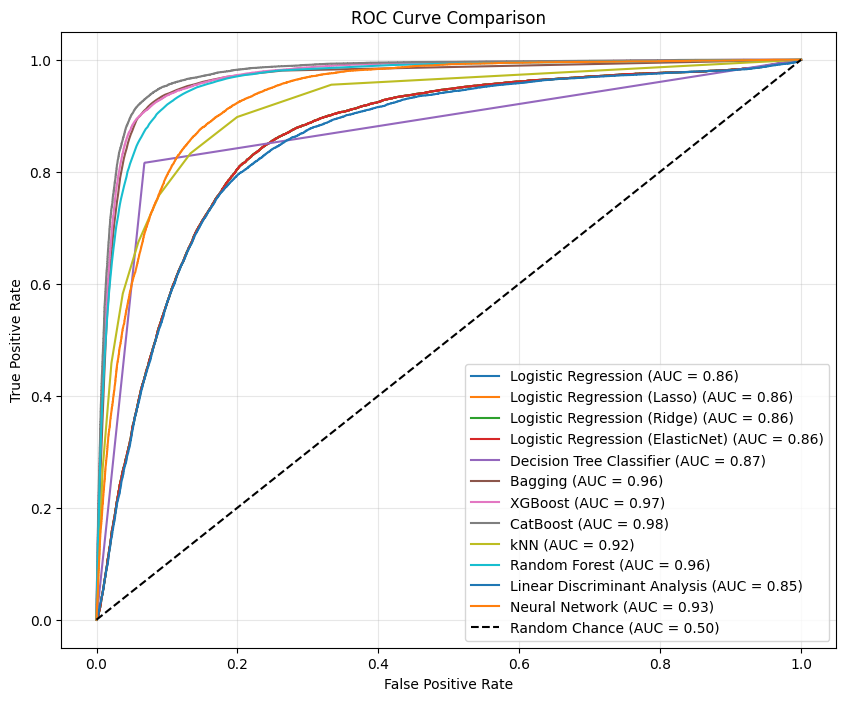

In [18]:
models = {
    "Logistic Regression": lr_pipe,
    "Logistic Regression (Lasso)": lasso_pipe,
    "Logistic Regression (Ridge)": ridge_pipe,
    "Logistic Regression (ElasticNet)": elasticnet_pipe_optimized,
    "Decision Tree Classifier": dtc_pipe,
    "Bagging": bagging_pipe,
    "XGBoost": xgboost_pipe,
    "CatBoost": catboost_pipe,
    "kNN": knn_pipe,
    "Random Forest": rf_pipe,
    "Linear Discriminant Analysis": lda_pipe,
    "Neural Network": mlp_pipe
}

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def calculate_cost_gain(y_true, y_pred, cost_fn_multiplier=5, gain_tp=0, gain_tn=1, cost_fp=0):
    # Compute the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Define costs and gains
    cost_fn = -cost_fn_multiplier * gain_tn  # Cost for false negatives

    # Calculate total cost-gain
    total_cost_gain = (tp * gain_tp) + (tn * gain_tn) + (fp * cost_fp) + (fn * cost_fn)

    # Confusion matrix components
    metrics = {"TN": tn, "FP": fp, "FN": fn, "TP": tp}
    
    return total_cost_gain, metrics

In [21]:
# Store cumulative gains and lift for each model
gains_data = {}
lift_data = {}

for model_name, model in models.items():
    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Sort probabilities and actual outcomes by descending predicted probability
    sorted_indices = np.argsort(y_proba)[::-1]
    y_test_array = np.array(y_test)  # Convert y_test to a NumPy array if not already
    sorted_y_test = y_test_array[sorted_indices]
    
    # Calculate cumulative gains
    total_positives = sum(y_test)  # Total number of positive outcomes
    cumulative_positives = np.cumsum(sorted_y_test)
    gains = cumulative_positives / total_positives  # Cumulative gains
    
    # Calculate lift
    percentage_of_data = np.arange(1, len(y_test) + 1) / len(y_test)
    lift = gains / percentage_of_data  # Lift over random
    
    # Store gains and lift
    gains_data[model_name] = (percentage_of_data, gains)
    lift_data[model_name] = (percentage_of_data, lift)

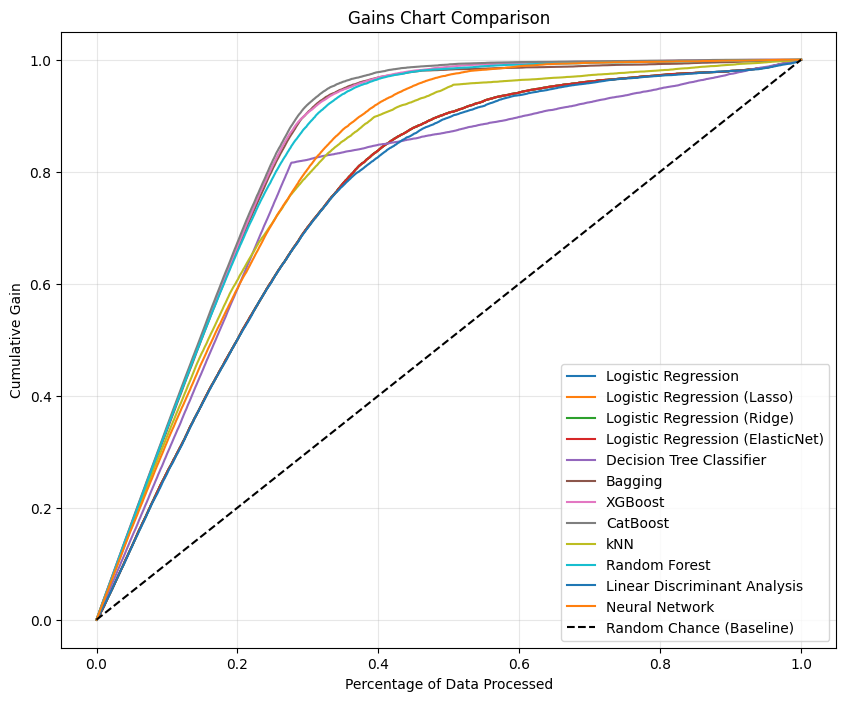

In [22]:
plt.figure(figsize=(10, 8))

# Plot gains for each model
for model_name, (percentage_of_data, gains) in gains_data.items():
    plt.plot(percentage_of_data, gains, label=model_name)

# Add a baseline (random selection)
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (Baseline)")

# Add labels, title, and legend
plt.xlabel('Percentage of Data Processed')
plt.ylabel('Cumulative Gain')
plt.title('Gains Chart Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

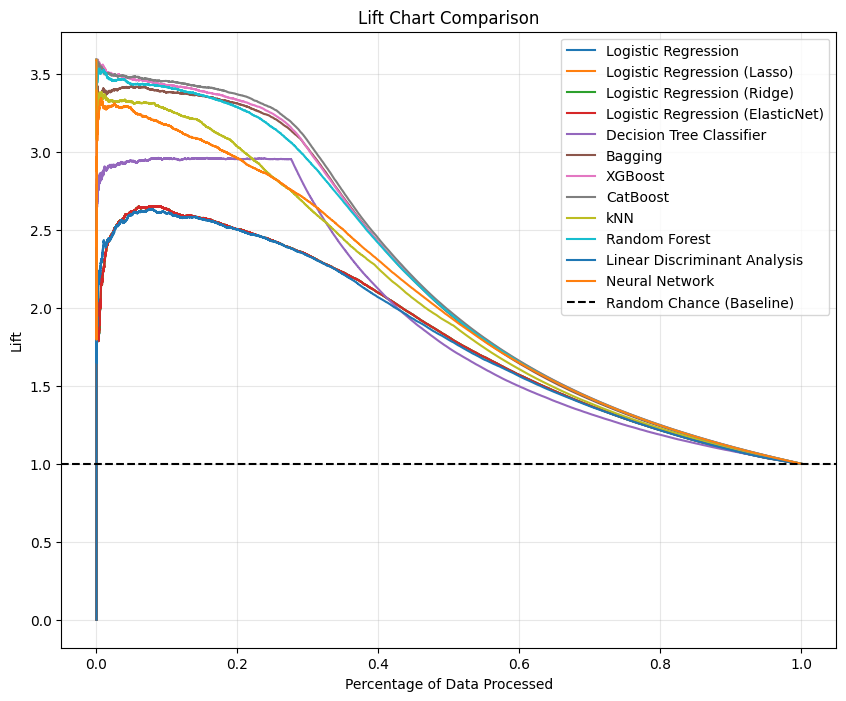

In [23]:
plt.figure(figsize=(10, 8))

# Plot lift for each model
for model_name, (percentage_of_data, lift) in lift_data.items():
    plt.plot(percentage_of_data, lift, label=model_name)

# Add a baseline (random selection)
plt.axhline(y=1, color='k', linestyle='--', label="Random Chance (Baseline)")

# Add labels, title, and legend
plt.xlabel('Percentage of Data Processed')
plt.ylabel('Lift')
plt.title('Lift Chart Comparison')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

In [26]:
cost_gain_results = {}

for model_name, model in models.items():
    # Get predictions for the test set
    y_pred = model.predict(X_test)
    
    # Calculate cost-gain
    total_cost_gain, metrics = calculate_cost_gain(y_test, y_pred, cost_fn_multiplier=5)
    
    # Store results
    cost_gain_results[model_name] = {
        "Total Cost-Gain": total_cost_gain,
        "Confusion Matrix": metrics
    }

# Display results
for model_name, results in cost_gain_results.items():
    print(f"Model: {model_name}")
    print(f"  Total Cost-Gain: {results['Total Cost-Gain']}")
    print(f"  Confusion Matrix: {results['Confusion Matrix']}")
    print()

Model: Logistic Regression
  Total Cost-Gain: 19309
  Confusion Matrix: {'TN': 37894, 'FP': 9137, 'FN': 3717, 'TP': 14445}

Model: Logistic Regression (Lasso)
  Total Cost-Gain: 19310
  Confusion Matrix: {'TN': 37895, 'FP': 9136, 'FN': 3717, 'TP': 14445}

Model: Logistic Regression (Ridge)
  Total Cost-Gain: 19309
  Confusion Matrix: {'TN': 37894, 'FP': 9137, 'FN': 3717, 'TP': 14445}

Model: Logistic Regression (ElasticNet)
  Total Cost-Gain: 19312
  Confusion Matrix: {'TN': 37897, 'FP': 9134, 'FN': 3717, 'TP': 14445}

Model: Decision Tree Classifier
  Total Cost-Gain: 27052
  Confusion Matrix: {'TN': 43837, 'FP': 3194, 'FN': 3357, 'TP': 14805}

Model: Bagging
  Total Cost-Gain: 33670
  Confusion Matrix: {'TN': 44545, 'FP': 2486, 'FN': 2175, 'TP': 15987}

Model: XGBoost
  Total Cost-Gain: 35587
  Confusion Matrix: {'TN': 43622, 'FP': 3409, 'FN': 1607, 'TP': 16555}

Model: CatBoost
  Total Cost-Gain: 37546
  Confusion Matrix: {'TN': 43691, 'FP': 3340, 'FN': 1229, 'TP': 16933}

Model: kN

### Optimizing best model

Catboost had the best results after testing so we will optimize the Catboost model, Optimize for f1 scoring since our dataset is unbalanced

In [29]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'auto_class_weights': 'Balanced',
        'cat_features': categorical_features,
        'verbose': 0,  # Suppress CatBoost logs
        'random_state': 42,
    }

    # Initialize and fit the CatBoostClassifier
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute evaluation metric (use your preferred metric)
    f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    return f1

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Train final model with the best parameters
best_params = study.best_params
best_params['auto_class_weights'] = 'Balanced'
best_params['cat_features'] = categorical_features
best_params['verbose'] = 0
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[I 2024-11-28 07:24:02,087] A new study created in memory with name: no-name-5b42d748-bdc4-4517-8227-c09dc5f27376
[I 2024-11-28 07:24:51,508] Trial 9 finished with value: 0.8755213595502708 and parameters: {'iterations': 159, 'learning_rate': 0.23832042576156717, 'depth': 6, 'l2_leaf_reg': 0.0015061032143077998, 'bagging_temperature': 0.36668425683812333}. Best is trial 9 with value: 0.8755213595502708.
[I 2024-11-28 07:27:13,163] Trial 3 finished with value: 0.8774273729998446 and parameters: {'iterations': 372, 'learning_rate': 0.23432138529722107, 'depth': 4, 'l2_leaf_reg': 0.008959240132397354, 'bagging_temperature': 0.8037736805395754}. Best is trial 3 with value: 0.8774273729998446.
[I 2024-11-28 07:28:26,574] Trial 5 finished with value: 0.8728183414231127 and parameters: {'iterations': 361, 'learning_rate': 0.059160870856202204, 'depth': 6, 'l2_leaf_reg': 0.0011317592871970493, 'bagging_temperature': 0.5294909779248597}. Best is trial 3 with value: 0.8774273729998446.
[I 2024-1

Best parameters: {'iterations': 781, 'learning_rate': 0.09922960276428117, 'depth': 9, 'l2_leaf_reg': 0.5703499609953481, 'bagging_temperature': 0.7203405247134401}
[[43894  3137]
 [ 1306 16856]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     47031
           1       0.84      0.93      0.88     18162

    accuracy                           0.93     65193
   macro avg       0.91      0.93      0.92     65193
weighted avg       0.94      0.93      0.93     65193



In [7]:
best_model = load("model.joblib")

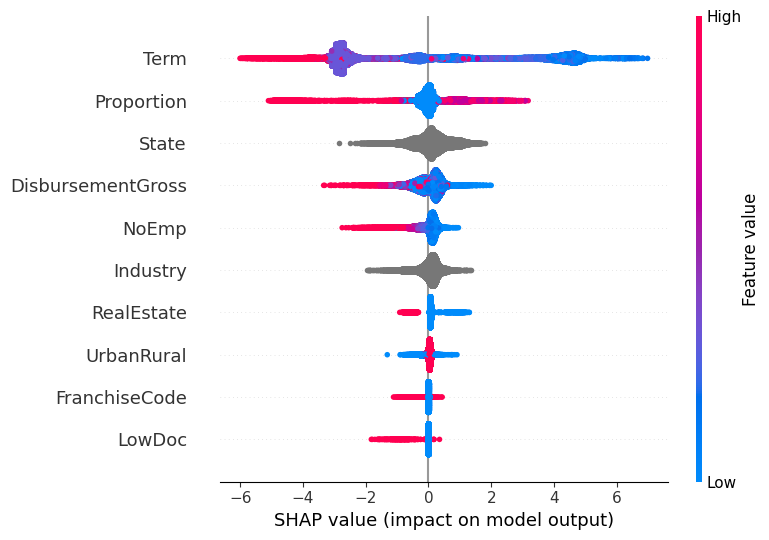

In [8]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

Find optimital thershold for maximum profitability

Best Threshold (Minimizing Cost): 0.32
Confusion Matrix at Best Threshold:
[[42364  4667]
 [  832 17330]]
Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     47031
           1       0.79      0.95      0.86     18162

    accuracy                           0.92     65193
   macro avg       0.88      0.93      0.90     65193
weighted avg       0.93      0.92      0.92     65193



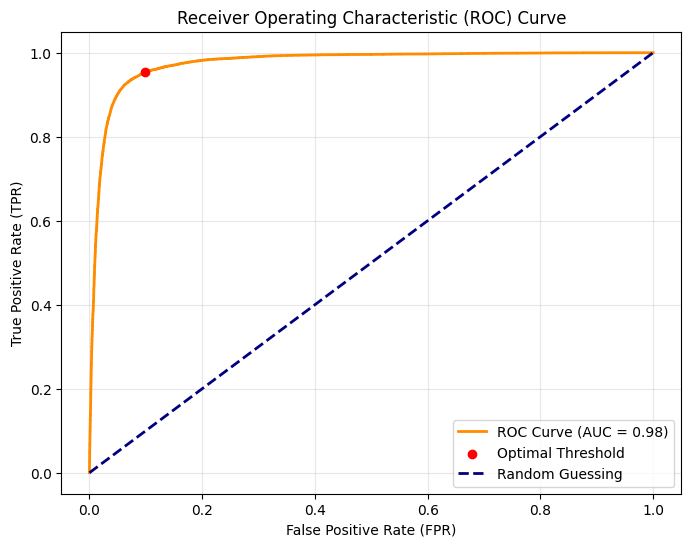

In [36]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Define cost for False Positives and False Negatives
cost_fn = 5  # Cost of FN
cost_fp = 1  # Cost of FP

# Compute costs for each threshold
costs = []
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)  # Predict based on threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # Get confusion matrix
    total_cost = (fp * cost_fp) + (fn * cost_fn)  # Compute total cost
    costs.append(total_cost)

# Find the threshold that minimizes the cost
best_threshold_index = np.argmin(costs)
best_threshold = thresholds[best_threshold_index]

# Print the best threshold
print(f"Best Threshold (Minimizing Cost): {best_threshold:.2f}")

# Apply the best threshold to make predictions
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Evaluate with the new threshold
print("Confusion Matrix at Best Threshold:")
print(confusion_matrix(y_test, y_pred_best))
print("Classification Report at Best Threshold:")
print(classification_report(y_test, y_pred_best))

# Plot ROC Curve with the optimal threshold highlighted
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label="Optimal Threshold", zorder=5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Exporting model and SHAP explainer

In [41]:
dump(explainer, 'shap_explainer.joblib')

['shap_explainer.joblib']

In [ ]:
dump(best_model, 'model.joblib')